In [1]:
"""
This code makes diagnostic plots for raw and postprocessed WRF-Solar output
Postprocessing using the Kalman Filter is from Rafael Alvarenga's code (rafael.alvarenga@etu.univ-guyane.fr)
"""
import glob
import os
import numpy as np
import pandas as pd
import csv

import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import pytz
import datetime
import math

from tqdm import tqdm

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from numpy import dot
from numpy.linalg import inv

In [2]:
tz = pytz.timezone("Asia/Manila")
resolution = '10Min'

In [3]:
a = pd.read_csv('with_flags.csv')
a['Time'] = pd.to_datetime(a['Time'])

a['ghi_obs'] = a['SPN1_Total_Solar']
a.columns

Index(['Unnamed: 0', 'Time', 'CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
       'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs'],
      dtype='object')

In [4]:
path = '/Users/apple/Desktop/Others/Python_Codes/wrf_solar/csv_2022_runs/' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))

mod_ = []

for f in all_files:
    mod = pd.read_csv(f)
    mod['Time'] = pd.to_datetime(mod['time'])#.dt.tz_localize(tz)
    mod = mod.set_index('Time')
    t0 = mod.index[0] + datetime.timedelta(hours=21)
    tf = t0 + datetime.timedelta(hours=14)
    mod['plot'] = 'N'
    mod.loc[((mod.index >= t0) & (mod.index<= tf)), 'plot'] = 'Y'
    mod=mod[mod['plot']=='Y']
    mod = mod.reset_index()
    mod_.append(mod)
    
mod_ = pd.concat(mod_)


mod_ = mod_[['Time', 'ens', 'ghi', 'swddni', 'coszen', 'swddif', 'lon', 'lat', 'hour', 'station_name',
       'domain']]


mod_ = pd.melt(mod_, id_vars=['Time', 'ens', 'domain', 'station_name'], value_vars=['ghi'] ,value_name='ghi_mod')


In [5]:
#MO

#ensmean
mod_d01 = mod_[(mod_['ens']== 'ensmean') & (mod_['domain']== 'd01') & (mod_['station_name']== 'MO')]
mod_d02 = mod_[(mod_['ens']== 'ensmean') & (mod_['domain']== 'd02') & (mod_['station_name']== 'MO')]
mod_d01

,Time,ens,domain,station_name,variable,ghi_mod
510,2020-02-12 05:00:00+08:00,ensmean,d01,MO,ghi,0.000000
511,2020-02-12 05:10:00+08:00,ensmean,d01,MO,ghi,0.000000
512,2020-02-12 05:20:00+08:00,ensmean,d01,MO,ghi,0.000000
513,2020-02-12 05:30:00+08:00,ensmean,d01,MO,ghi,0.000000
514,2020-02-12 05:40:00+08:00,ensmean,d01,MO,ghi,0.000000
...,...,...,...,...,...,...
27110,2020-07-14 18:20:00+08:00,ensmean,d01,MO,ghi,7.560263
27111,2020-07-14 18:30:00+08:00,ensmean,d01,MO,ghi,0.000000
27112,2020-07-14 18:40:00+08:00,ensmean,d01,MO,ghi,0.000000
27113,2020-07-14 18:50:00+08:00,ensmean,d01,MO,ghi,0.000000


In [6]:
mod_d01.to_csv('sample.csv')

In [7]:
mod_d01  = mod_d01.set_index('Time')
#mod_d01  = mod_d01.resample(resolution).interpolate(method='linear')
mod_d01  = mod_d01.reset_index(drop = False)
mod_d01['station_name']  = 'MO'
mod_d01['domain']  = 'd01'
mod_d01['ens']  = 'ensmean'

mod_d02  = mod_d02.set_index('Time')
#mod_d02  = mod_d02.resample(resolution).interpolate(method='linear')
mod_d02  = mod_d02.reset_index(drop = False)
mod_d02['station_name']  = 'MO'
mod_d02['domain']  = 'd02'
mod_d02['ens']  = 'ensmean'

d01_mo_mean = a.merge(mod_d01, how='inner', on='Time')
d01_mo_mean['Time'] = pd.to_datetime(d01_mo_mean['Time']).dt.tz_convert(tz)


d01_mo_mean = d01_mo_mean.set_index('Time')
d01_mo_mean['YY'] = pd.DatetimeIndex(d01_mo_mean.index).year
d01_mo_mean['MM'] = pd.DatetimeIndex(d01_mo_mean.index).month
d01_mo_mean['DD'] = pd.DatetimeIndex(d01_mo_mean.index).day
d01_mo_mean['HH'] = pd.DatetimeIndex(d01_mo_mean.index).hour
d01_mo_mean['mm'] = pd.DatetimeIndex(d01_mo_mean.index).minute
d01_mo_mean = d01_mo_mean.reset_index()


d02_mo_mean = a.merge(mod_d02, how='inner', on='Time')
d02_mo_mean['Time'] = pd.to_datetime(d02_mo_mean['Time']).dt.tz_convert(tz)


d02_mo_mean = d02_mo_mean.set_index('Time')
d02_mo_mean['YY'] = pd.DatetimeIndex(d02_mo_mean.index).year
d02_mo_mean['MM'] = pd.DatetimeIndex(d02_mo_mean.index).month
d02_mo_mean['DD'] = pd.DatetimeIndex(d02_mo_mean.index).day
d02_mo_mean['HH'] = pd.DatetimeIndex(d02_mo_mean.index).hour
d02_mo_mean['mm'] = pd.DatetimeIndex(d02_mo_mean.index).minute
d02_mo_mean = d02_mo_mean.reset_index()


In [8]:
d01_mo_mean

,Time,Unnamed: 0,CMP22_Total_Solar,SPN1_Total_Solar,SPN1_Diff_Solar,CGR4_IR,dhi,ghi_a,sza,cossza,...,dhi_cc_val,t1_lim,flag_clear,ghi_obs,ens,domain,station_name,variable,ghi_mod,YY
0,2020-02-12 06:30:00+08:00,4819,0.036084,32.570943,19.644241,1188.706674,19.644241,32.570943,88.436221,0.027290,...,NaN,900,N,32.570943,ensmean,d01,MO,ghi,2.246928,2020
1,2020-02-12 06:40:00+08:00,4820,0.085233,75.840541,40.826524,1190.492085,40.826524,75.840541,86.234841,0.065667,...,NaN,900,N,75.840541,ensmean,d01,MO,ghi,29.527308,2020
2,2020-02-12 06:50:00+08:00,4821,0.087301,77.501163,40.200810,1192.385807,40.200810,77.501163,83.968019,0.105084,...,NaN,900,N,77.501163,ensmean,d01,MO,ghi,70.363630,2020
3,2020-02-12 07:00:00+08:00,4822,0.090924,79.459003,38.112329,1193.229103,38.112329,79.459003,81.681666,0.144673,...,38.112329,900,Y,79.459003,ensmean,d01,MO,ghi,84.300800,2020
4,2020-02-12 07:10:00+08:00,4823,0.086342,84.275998,74.104677,1195.367595,74.104677,84.275998,79.391464,0.184098,...,NaN,900,N,84.275998,ensmean,d01,MO,ghi,111.331310,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,2020-07-14 17:40:00+08:00,15689,0.038884,41.610754,32.482459,1251.887496,32.482459,41.610754,79.693064,0.178921,...,NaN,900,N,41.610754,ensmean,d01,MO,ghi,60.146816,2020
1027,2020-07-14 17:50:00+08:00,15690,0.012997,15.762750,14.523008,1248.926084,14.523008,15.762750,81.943208,0.140155,...,NaN,900,N,15.762750,ensmean,d01,MO,ghi,55.321537,2020
1028,2020-07-14 18:00:00+08:00,15691,0.011458,14.311563,11.977640,1248.193523,11.977640,14.311563,84.172838,0.101528,...,NaN,900,N,14.311563,ensmean,d01,MO,ghi,41.865723,2020
1029,2020-07-14 18:10:00+08:00,15692,0.002525,5.999038,4.814235,1246.817284,4.814235,5.999038,86.366496,0.063374,...,NaN,900,N,5.999038,ensmean,d01,MO,ghi,15.957787,2020


In [9]:
df = d01_mo_mean
if 'Error_rel' not in df.columns:
    # Function to calculate relative errors
    def calculate_relative_errors(pred, obs):
        if obs == 0:
            return np.nan
        else:
            return (pred - obs)/obs
    # recalculate relative error after removing some observations
    df['Error_rel'] = df.apply(lambda row : calculate_relative_errors(row['ghi_mod'], row['ghi_obs']), axis = 1)


In [10]:
#line 221
df['Kc_GHI_pred'] = df['ghi_mod']/df['GHI_in']
df['Kc_GHI_pred'] = df['Kc_GHI_pred'].replace(np.inf,np.nan)

##############################
#CHECK THIS###################
##############################
df['Kc_GHI_obs'] = df['ghi_obs']/df['GHI_in']

#line 223
# create clear-sky index column for observed errors 
df['Kc_obs_bias'] = df['Kc_GHI_pred'] - df['Kc_GHI_obs']




In [11]:

df['LT'] = (df['HH']*60)+df['mm']
df

,Time,Unnamed: 0,CMP22_Total_Solar,SPN1_Total_Solar,SPN1_Diff_Solar,CGR4_IR,dhi,ghi_a,sza,cossza,...,domain,station_name,variable,ghi_mod,YY,Error_rel,Kc_GHI_pred,Kc_GHI_obs,Kc_obs_bias,LT
0,2020-02-12 06:30:00+08:00,4819,0.036084,32.570943,19.644241,1188.706674,19.644241,32.570943,88.436221,0.027290,...,d01,MO,ghi,2.246928,2020,-0.931014,1.444845,20.944136,-19.499291,390
1,2020-02-12 06:40:00+08:00,4820,0.085233,75.840541,40.826524,1190.492085,40.826524,75.840541,86.234841,0.065667,...,d01,MO,ghi,29.527308,2020,-0.610666,2.202990,5.658353,-3.455363,400
2,2020-02-12 06:50:00+08:00,4821,0.087301,77.501163,40.200810,1192.385807,40.200810,77.501163,83.968019,0.105084,...,d01,MO,ghi,70.363630,2020,-0.092096,1.858800,2.047352,-0.188553,410
3,2020-02-12 07:00:00+08:00,4822,0.090924,79.459003,38.112329,1193.229103,38.112329,79.459003,81.681666,0.144673,...,d01,MO,ghi,84.300800,2020,0.060935,1.193626,1.125070,0.068556,420
4,2020-02-12 07:10:00+08:00,4823,0.086342,84.275998,74.104677,1195.367595,74.104677,84.275998,79.391464,0.184098,...,d01,MO,ghi,111.331310,2020,0.321032,1.029361,0.779210,0.250151,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,2020-07-14 17:40:00+08:00,15689,0.038884,41.610754,32.482459,1251.887496,32.482459,41.610754,79.693064,0.178921,...,d01,MO,ghi,60.146816,2020,0.445463,0.786805,0.544327,0.242478,1060
1027,2020-07-14 17:50:00+08:00,15690,0.012997,15.762750,14.523008,1248.926084,14.523008,15.762750,81.943208,0.140155,...,d01,MO,ghi,55.321537,2020,2.509637,1.189091,0.338807,0.850283,1070
1028,2020-07-14 18:00:00+08:00,15691,0.011458,14.311563,11.977640,1248.193523,11.977640,14.311563,84.172838,0.101528,...,d01,MO,ghi,41.865723,2020,1.925307,1.874274,0.640710,1.233564,1080
1029,2020-07-14 18:10:00+08:00,15692,0.002525,5.999038,4.814235,1246.817284,4.814235,5.999038,86.366496,0.063374,...,d01,MO,ghi,15.957787,2020,1.660058,2.443553,0.918609,1.524944,1090


In [12]:
# ----------------------------
#    Remove early morning and late afternoon
# ----------------------------
df_temp = df.loc[(df['Time'].dt.hour >= 8) & (df['Time'].dt.hour <= 17)].copy()
idx_remove = df_temp.loc[(df_temp['Time'].dt.hour == 17) & (df_temp['Time'].dt.minute != 0)].index
df_temp.drop(idx_remove, axis=0, inplace=True)
df_temp = df_temp.reset_index(drop = False)

In [13]:
#for predictors_vector in [['Kc_GHI_pred','Q2_rel']]:# [results_best_MBE.loc[results_best_MBE.index[-1], 'Predictors'].split('-')[1:], results_best_MAE.loc[results_best_MAE.index[-1], 'Predictors'].split('-')[1:]]:
#df_temp = df.copy()
df_temp['Kc_GHI_pred_improved'] = np.nan 

##############################
#CHECK THIS###################
##############################
df_temp['predicted_coefs'] = np.nan 
df_temp =  df_temp[['Time', 'LT','CMP22_Total_Solar', 'SPN1_Total_Solar',
       'SPN1_Diff_Solar', 'CGR4_IR', 'YY', 'MM', 'HH', 'mm', 'dhi',
       'ghi_obs', 'sza', 'cossza', 'dni',  'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
       'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
       'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
       'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear',\
         'ens', 'domain','station_name', 'ghi_mod', 'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias',
       'Kc_GHI_pred_improved']]


In [14]:
df_temp

,Time,LT,CMP22_Total_Solar,SPN1_Total_Solar,SPN1_Diff_Solar,CGR4_IR,YY,MM,HH,mm,...,flag_clear,ens,domain,station_name,ghi_mod,Error_rel,Kc_GHI_pred,Kc_GHI_obs,Kc_obs_bias,Kc_GHI_pred_improved
0,2020-02-12 08:00:00+08:00,480,0.211280,210.676890,172.334359,1204.779355,2020,2,8,0,...,N,ensmean,d01,MO,315.26663,0.496446,0.996057,0.665615,0.330442,NaN
1,2020-02-12 08:10:00+08:00,490,0.156264,158.477615,146.294132,1204.909765,2020,2,8,10,...,N,ensmean,d01,MO,408.49500,1.577620,1.140653,0.442522,0.698131,NaN
2,2020-02-12 08:20:00+08:00,500,0.205744,210.605773,185.878716,1210.347557,2020,2,8,20,...,N,ensmean,d01,MO,458.18896,1.175576,1.148239,0.527786,0.620453,NaN
3,2020-02-12 08:30:00+08:00,510,0.481803,487.368274,219.753823,1217.401030,2020,2,8,30,...,N,ensmean,d01,MO,505.04138,0.036262,1.150215,1.109966,0.040250,NaN
4,2020-02-12 08:40:00+08:00,520,0.479284,486.834465,215.728214,1219.643179,2020,2,8,40,...,N,ensmean,d01,MO,542.03370,0.113384,1.133667,1.018218,0.115450,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,2020-07-14 16:20:00+08:00,980,0.309956,345.968680,77.013197,1267.662772,2020,7,16,20,...,N,ensmean,d01,MO,315.49237,-0.088090,0.835265,0.915951,-0.080686,NaN
766,2020-07-14 16:30:00+08:00,990,0.269672,306.184167,72.832534,1266.163152,2020,7,16,30,...,N,ensmean,d01,MO,241.25424,-0.212062,0.711550,0.903053,-0.191503,NaN
767,2020-07-14 16:40:00+08:00,1000,0.233631,262.500367,65.281560,1264.380865,2020,7,16,40,...,N,ensmean,d01,MO,183.47394,-0.301053,0.611398,0.874740,-0.263343,NaN
768,2020-07-14 16:50:00+08:00,1010,0.214402,236.766827,63.174655,1263.984081,2020,7,16,50,...,N,ensmean,d01,MO,153.99847,-0.349578,0.589980,0.907072,-0.317092,NaN


In [15]:

nb_LTs = len(np.unique(df_temp.LT))

idx_t = 0
recursive_calculation_covariance_matrices = True
add_noise_in_predictions = False
nonlinear_predictions = False
predictors_vector = ['Kc_GHI_pred', 'cossza']

In [16]:
'''for nb_historical_days in [2,3,4,5,6,7,9,11]:
#for nb_historical_days in [12,13,14,15,16,17,19,21]:
#for nb_historical_days in [22,23,24,25]:
    for t in tqdm(range(len(df_temp))):

        hour = df_temp.loc[t,'Time'].hour
        minutes = df_temp.loc[t,'Time'].minute
        #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')

        timestep_enough_historical = (nb_historical_days*2)*nb_LTs  
        
        if t >= timestep_enough_historical:
            # slice df
            df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
        else:
            df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
            df_timestep = df_timestep[::-1].reset_index(drop=True)
        df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]

        if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
            df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
            continue

        df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
        df_timestep = df_timestep.reset_index(drop = True)

        # define prediction-bias variance matrix
        W = np.eye(len(predictors_vector))/1000

        # define measurement-bias variance matrix
        V = 0.01

        # define initial error covariance matrix
        Po = np.eye(len(predictors_vector))*5

        # define initial predicted bias
        xo = np.zeros(len(predictors_vector)).reshape(len(predictors_vector),1)

        measurement_GHI = []
        old_predicted_GHI = []
        improved_GHI = []
        ground_truths = []
        predicted_coefs = []

        for idx_i, i in enumerate(df_timestep.index):
            if recursive_calculation_covariance_matrices == True:
                # --------------------------------------------
                #  Calculate matrices of covariance of errors
                # --------------------------------------------
                if idx_i > nb_historical_days:
                    mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                    mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                    # old method
                    W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                    V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))

                    # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                    # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                    # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))

            # ----------------------------
            #           Predict
            # ----------------------------

            if idx_i == 0:
                # predicted mean bias
                x_pred = np.zeros_like(xo)
                if add_noise_in_predictions == True:
                    x_pred = xo + np.random.multivariate_normal(mean=[0.5]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = xo

                # predicted bias covariance matrix
                P = Po + W

            else:
                # predicted mean bias
                if add_noise_in_predictions == True:
                    x_pred = x_pred + np.random.multivariate_normal(mean=[0]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = x_pred
                #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors

                # predicted bias covariance matrix
                P = P + W

            # ----------------------------
            #           Update
            # ----------------------------

            # compute transition matrix based on the current predictors for this timestep
            H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
            H = np.asarray([1] + H).reshape(1, len(predictors_vector))
            if nonlinear_predictions == True:
                H = [predictor**idx_predictor for idx_predictor, predictor in enumerate(H)]

            predicted_coefs.append(x_pred)
            improved_GHI.append(dot(H,x_pred))
            df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]

            # compute residual mean bias and residual bias covariance
            if add_noise_in_predictions == True:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs'] + np.random.normal(loc = 0, scale = V)
            else:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
            residual_mean = new_measurement - dot(H,x_pred)
            residual_covariance = dot(H, P).dot(H.T) + V

            # compute Kalman gain based on the transition matrix and residual covariance
            K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
            K = np.nan_to_num(K, nan = 0)

            # update mean bias after incorporating measurements
            x_pred = x_pred + dot(K,residual_mean)

            # update bias covariance matrix after incorporating measurements
            #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
            P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)

            measurement_GHI.append(new_measurement)
            old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
            ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])

        # assign final prediction
        df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
    # calculate overall error metrics for this group of predictors
    df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

    df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
    df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

    rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
    mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])

    print('\n\n**************************')
    print(f'{nb_historical_days}')
    print(f'- RMS: {rms}')
    print(f'- MAE: {mae}')
    #print(f'- MSE: {mse}')
    print(f'- MBE: {mbe}')
'''

"for nb_historical_days in [2,3,4,5,6,7,9,11]:\n#for nb_historical_days in [12,13,14,15,16,17,19,21]:\n#for nb_historical_days in [22,23,24,25]:\n    for t in tqdm(range(len(df_temp))):\n\n        hour = df_temp.loc[t,'Time'].hour\n        minutes = df_temp.loc[t,'Time'].minute\n        #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')\n\n        timestep_enough_historical = (nb_historical_days*2)*nb_LTs  \n        \n        if t >= timestep_enough_historical:\n            # slice df\n            df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()\n        else:\n            df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()\n            df_timestep = df_timestep[::-1].reset_index(drop=True)\n        df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]\

In [17]:
def fitting(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['ghi_mod'])
    xaa = x_a[~np.isnan(x_a)]
    yaa = y_a[~np.isnan(y_a)]
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    #print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    alpha = 0.01
    #if p > alpha:
        #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    #else:
        #print('Samples are correlated (reject H0) p=%.3f' % p)

    #print('Pearsons correlation: %.3f' % pearson_corr)
    #print('Pearsons p_value: %.3f' % pearson_pval)
    #print('RMS: %.3f' % rms)
    #print('MAE: %.3f' % mae)
    #print('###########################################')
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms, mae)

def fitting_pred(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['GHI_pred_improved_fin'])
    xaa = x_a[~np.isnan(x_a)]
    yaa = y_a[~np.isnan(y_a)]

    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    #print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    
    alpha = 0.01
    #if p > alpha:
        #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    #else:
        #print('Samples are correlated (reject H0) p=%.3f' % p)

    #print('Pearsons correlation: %.3f' % pearson_corr)
    #print('RMS: %.3f' % rms)
    #print('MAE: %.3f' % mae)
    #print('###########################################')
    
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms, mae)
###########################

def kf_fitting(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['GHI_pred_kf_only'])
    xaa = x_a[~np.isnan(x_a)]
    yaa = y_a[~np.isnan(y_a)]
    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    #print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    alpha = 0.01
    #if p > alpha:
        #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    #else:
        #print('Samples are correlated (reject H0) p=%.3f' % p)

    #print('Pearsons correlation: %.3f' % pearson_corr)
    #print('Pearsons p_value: %.3f' % pearson_pval)
    #print('RMS: %.3f' % rms)
    #print('MAE: %.3f' % mae)
    #print('###########################################')
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms, mae)

def kf_fitting_pred(da):

    x_new = np.linspace(0.01, 1360, 1000)
    x_a=np.array(da['ghi_obs'])
    y_a=np.array(da['GHI_pred_kf_only'])
    xaa = x_a[~np.isnan(x_a)]
    yaa = y_a[~np.isnan(y_a)]

    slope_a, intercept_a, r_value_a, p_value_a, std_err_a = stats.linregress(x_a,y_a)
    pearson_corr, pearson_pval = pearsonr(xaa,yaa)
    coef, p = kendalltau(xaa,yaa)
    #print('Kendall correlation coefficient: %.3f' % coef)
    rms = mean_squared_error(xaa, yaa, squared=False)
    mae = mean_absolute_error(xaa, yaa)
    
    alpha = 0.01
    #if p > alpha:
        #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    #else:
        #print('Samples are correlated (reject H0) p=%.3f' % p)

    #print('Pearsons correlation: %.3f' % pearson_corr)
    #print('RMS: %.3f' % rms)
    #print('MAE: %.3f' % mae)
    #print('###########################################')
    
    return (pearson_corr, pearson_pval, slope_a, intercept_a, r_value_a, p_value_a, std_err_a, rms, mae)



In [34]:
def ts_all(res, da_mean):
    da_mean= da_mean
    fig = plt.figure()
    gs = fig.add_gridspec(6, 3)

    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=1.5)
    ax00.plot(da_mean.index,da_mean['ghi_mod'],c='red',linewidth=1.)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.text(100, 1500, 'Manila Observatory WRF-Solar validation (' + str(res)+' km | initialized 00 UTC previous day)',  fontsize=5)
    #ax00.text(100, 1300, 'ensmean v obs',  fontsize=5)   
    ax00.text( 100, 1100,'WRF RMSE = %0.2f'%fitting(da_mean)[7], fontsize=5, color='red')
    ax00.legend(['Obs','WRF-' + str(res) + 'km'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.set_xticklabels([])
    
    ax00 = fig.add_subplot(gs[2:3, 0:3])
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=1.5)
    ax00.plot(da_mean.index,da_mean['GHI_pred_improved_fin'],c='c',linewidth=1.0)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.text( 100, 1100,'KFv2-WRF RMSE = %0.2f'%fitting_pred(da_mean)[7], fontsize=5, color='c')
    ax00.legend(['Obs','KF+'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.set_xticklabels([])
    
    ax00 = fig.add_subplot(gs[1:2, 0:3])
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=1.5)
    ax00.plot(da_mean.index,da_mean['GHI_pred_kf_only'],c='green',linewidth=1.0) 
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)  
    ax00.text( 100, 1100,'KF-WRF RMSE = %0.2f'%kf_fitting_pred(da_mean)[7], fontsize=5, color='green')
    ax00.legend(['Obs','KF only'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.set_xticklabels([])
    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/all_kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
    
    
    with open(f'2022_{nb_historical_days}.csv', 'w') as fileObj:
        writerObj = csv.writer(fileObj)
        writerObj.writerow(['label','pearson_corr', 'rms', 'mae'])
        wrf = ('WRF all',fitting(da_mean)[0],fitting(da_mean)[7],fitting(da_mean)[8])
        kf = ('KF all',fitting_pred(da_mean)[0],fitting_pred(da_mean)[7],fitting_pred(da_mean)[8])
        writerObj.writerow(wrf)
        writerObj.writerow(kf) 
        fileObj.close()


############################
############################
############################
def ts_cut(res, da_mean):
    da_mean = da_mean.iloc[nb_LTs*nb_historical_days:,:] #

    fig = plt.figure()
    gs = fig.add_gridspec(6, 3)

    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=1.5)
    ax00.plot(da_mean.index,da_mean['ghi_mod'],c='red',linewidth=1.)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.text(100, 1500, 'Manila Observatory WRF-Solar validation (' + str(res)+' km | initialized 00 UTC previous day)',  fontsize=5)
    #ax00.text(100, 1300, 'ensmean v obs',  fontsize=5)   
    ax00.text( 100, 1100,'WRF RMSE = %0.2f'%fitting(da_mean)[7], fontsize=5, color='red')
    ax00.legend(['Obs','WRF-' + str(res) + 'km'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.set_xticklabels([])
    
    ax00 = fig.add_subplot(gs[2:3, 0:3])
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=1.5)
    ax00.plot(da_mean.index,da_mean['GHI_pred_improved_fin'],c='c',linewidth=1.0)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.text( 100, 1100,'KFv2-WRF RMSE = %0.2f'%fitting_pred(da_mean)[7], fontsize=5, color='c')
    ax00.legend(['Obs','KF+'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
    ax00.set_xticklabels([])
    
    ax00 = fig.add_subplot(gs[1:2, 0:3])
    ax00.plot(da_mean.index,da_mean['ghi_obs'],c='DarkBlue',linewidth=1.5)
    ax00.plot(da_mean.index,da_mean['GHI_pred_kf_only'],c='green',linewidth=1.0) 
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)  
    ax00.text( 100, 1100,'KF-WRF RMSE = %0.2f'%kf_fitting_pred(da_mean)[7], fontsize=5, color='green')
    ax00.legend(['Obs','KF only'], bbox_to_anchor=(1.02, 0.98), prop={'size': 5},loc=2, borderaxespad=0.)
       
 
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/cut_kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")

    with open(f'2022_{nb_historical_days}.csv', 'a') as f_object:
        writerObj = csv.writer(f_object)
        wrf = ('WRF cut',fitting(da_mean)[0],fitting(da_mean)[7],fitting(da_mean)[8])
        kf = ('KF cut',fitting_pred(da_mean)[0],fitting_pred(da_mean)[7],fitting_pred(da_mean)[8])
        writerObj.writerow(wrf)
        writerObj.writerow(kf)
        f_object.close()


############################
############################
############################    
def scat_all(res, da_mean):   
    plt_da = da_mean
    x_new = np.linspace(0.01, 1360, 1000)
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)   
    
    ax00 = fig.add_subplot(gs[0:1, 8:11])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='c',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='c')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='c')  
    ax00.text( 200, 1390,'KF+ WRF-Solar '+ str(res) + '-km', fontsize=5, color='c')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')

        
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_kf_only'],c='green',s=0.1,alpha=0.6)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%kf_fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%kf_fitting_pred(plt_da)[7], fontsize=3, color='green')  
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -800, 1600,'All Periods', fontsize=5, color='k')
    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/all_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


############################
############################
############################ 
def scat_cut(res, da_mean):   
    x_new = np.linspace(0.01, 1360, 1000)
    plt_da = da_mean.iloc[nb_LTs*nb_historical_days:,:] #
    
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15) 
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)   
    
    
    ax00 = fig.add_subplot(gs[0:1, 8:11])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='c',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='c')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='c')  
    ax00.text( 200, 1390,'KF+ WRF-Solar '+ str(res) + '-km', fontsize=5, color='c')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')

        
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_kf_only'],c='green',s=0.1,alpha=0.6)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%kf_fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%kf_fitting_pred(plt_da)[7], fontsize=3, color='green')  
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -800, 1600,'All Periods', fontsize=5, color='k')
    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/cut_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")


############################
############################
############################ 

def scat_cloudy_all(res, da_mean):
    x_new = np.linspace(0.01, 1360, 1000)
    plt_da = da_mean
    plt_da = plt_da[plt_da['flag_clear'] == 'N']
    
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])    
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
        
    
    ax00 = fig.add_subplot(gs[0:1, 8:11])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='c',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='c')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='c')  
    ax00.text( 200, 1390,'KF+ WRF-Solar '+ str(res) + '-km', fontsize=5, color='c')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')

        
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_kf_only'],c='green',s=0.1,alpha=0.6)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%kf_fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%kf_fitting_pred(plt_da)[7], fontsize=3, color='green')  
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -800, 1600,'Cloudy Periods', fontsize=5, color='k')
    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
    
    with open(f'2022_{nb_historical_days}.csv', 'a') as f_object:
        writerObj = csv.writer(f_object)
        wrf = ('WRF cloudy all',fitting(plt_da)[0],fitting(plt_da)[7],fitting(plt_da)[8])
        kf = ('KF cloudy all',fitting_pred(plt_da)[0],fitting_pred(plt_da)[7],fitting_pred(plt_da)[8])
        writerObj.writerow(wrf)
        writerObj.writerow(kf)
        f_object.close()
        
############################
############################
############################ 
def scat_cloudy_cut(res, da_mean):

    x_new = np.linspace(0.01, 1360, 1000)
    plt_da = da_mean.iloc[nb_LTs*nb_historical_days:,:] #
    plt_da = plt_da[plt_da['flag_clear'] == 'N']
    
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    ax00 = fig.add_subplot(gs[0:1, 8:11])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='c',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='c')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='c')  
    ax00.text( 200, 1390,'KF+ WRF-Solar '+ str(res) + '-km', fontsize=5, color='c')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')

        
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_kf_only'],c='green',s=0.1,alpha=0.6)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%kf_fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%kf_fitting_pred(plt_da)[7], fontsize=3, color='green')  
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -800, 1600,'Cloudy Periods', fontsize=5, color='k')
    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/cut_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
    
    with open(f'2022_{nb_historical_days}.csv', 'a') as f_object:
        writerObj = csv.writer(f_object)
        wrf = ('WRF cloudy cut',fitting(plt_da)[0],fitting(plt_da)[7],fitting(plt_da)[8])
        kf = ('KF cloudy cut',fitting_pred(plt_da)[0],fitting_pred(plt_da)[7],fitting_pred(plt_da)[8])
        writerObj.writerow(wrf)
        writerObj.writerow(kf)
        f_object.close()
############################
############################
############################         
def scat_clear_all(res, da_mean):

    x_new = np.linspace(0.01, 1360, 1000)
    plt_da = da_mean
    plt_da = plt_da[plt_da['flag_clear'] == 'Y']
    
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5) 
    
    ax00 = fig.add_subplot(gs[0:1, 8:11])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='c',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='c')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='c')  
    ax00.text( 200, 1390,'KF+ WRF-Solar '+ str(res) + '-km', fontsize=5, color='c')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')

        
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_kf_only'],c='green',s=0.1,alpha=0.6)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%kf_fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%kf_fitting_pred(plt_da)[7], fontsize=3, color='green')  
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -800, 1600,'Clear Sky Periods', fontsize=5, color='k')
    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/all_clear_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
   
    with open(f'2022_{nb_historical_days}.csv', 'a') as f_object:
        writerObj = csv.writer(f_object)
        wrf = ('WRF clear all',fitting(plt_da)[0],fitting(plt_da)[7],fitting(plt_da)[8])
        kf = ('KF clear all',fitting_pred(plt_da)[0],fitting_pred(plt_da)[7],fitting_pred(plt_da)[8])
        writerObj.writerow(wrf)
        writerObj.writerow(kf)
        f_object.close()
############################
############################
############################ 
def scat_clear_cut(res, da_mean):
    x_new = np.linspace(0.01, 1360, 1000)
    plt_da = da_mean.iloc[nb_LTs*nb_historical_days:,:] #
    plt_da = plt_da[plt_da['flag_clear'] == 'Y']
    fig = plt.figure()
    gs = fig.add_gridspec(4, 15)
    
    ax00 = fig.add_subplot(gs[0:1, 0:3])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['ghi_mod'],c='red',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting(plt_da)[7], fontsize=3, color='red')
    ax00.text( 50, 1100,'R* = %0.2f'%fitting(plt_da)[0], fontsize=3, color='red')
    ax00.text( 200, 1390,'WRF-Solar '+ str(res) + '-km', fontsize=5, color='red')
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.set_ylabel('Model\nGHI (W/m$^2$)',  fontsize=5)
    
    
    ax00 = fig.add_subplot(gs[0:1, 8:11])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_improved_fin'],c='c',s=0.1,alpha=0.5)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%fitting_pred(plt_da)[0], fontsize=3, color='c')
    ax00.text( 50, 1000,'RMSE = %0.2f'%fitting_pred(plt_da)[7], fontsize=3, color='c')  
    ax00.text( 200, 1390,'KF+ WRF-Solar '+ str(res) + '-km', fontsize=5, color='c')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -500, -800,'Observed\nGHI (W/m$^2$)', fontsize=5, color='k')

        
    ax00 = fig.add_subplot(gs[0:1, 4:7])
    ax00.scatter(x=plt_da['ghi_obs'],y=plt_da['GHI_pred_kf_only'],c='green',s=0.1,alpha=0.6)
    plt.plot(x_new,x_new,c='gray',linewidth=0.1)
    ax00.tick_params(axis='both', which='major', labelsize=5)
    ax00.text( 50, 1100,'R* = %0.2f'%kf_fitting_pred(plt_da)[0], fontsize=3, color='green')
    ax00.text( 50, 1000,'RMSE = %0.2f'%kf_fitting_pred(plt_da)[7], fontsize=3, color='green')  
    ax00.text( 200, 1390,'KF WRF-Solar '+ str(res) + '-km', fontsize=5, color='green')
    ax00.set_ylim(0,1360)
    ax00.set_xlim(0,1360)
    ax00.text( -800, 1600,'Clear Sky Periods', fontsize=5, color='k')    
    images_dir = 'img/2022_runs'
    plt.savefig(f"{images_dir}/{nb_historical_days}days/cut_clear_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
   
    with open(f'2022_{nb_historical_days}.csv', 'a') as f_object:
        writerObj = csv.writer(f_object)
        wrf = ('WRF clear cut',fitting(plt_da)[0],fitting(plt_da)[7],fitting(plt_da)[8])
        kf = ('KF clear cut',fitting_pred(plt_da)[0],fitting_pred(plt_da)[7],fitting_pred(plt_da)[8])
        writerObj.writerow(wrf)
        writerObj.writerow(kf)
        f_object.close()


100%|█████████████████████████████████████████| 770/770 [00:18<00:00, 41.19it/s]




**************************
Predictors: ['Kc_GHI_pred', 'cossza']
- RMS: 251.61719389668428
- MAE: 177.9566972366288
- MBE: -12.627881969164607


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1535/1695895641.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/{nb_historical_days}days/all_kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1535/1695895641.py:88: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/{nb_historical_days}days/cut_kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1535/1695895641.py:143: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no



**************************
Predictors: ['Kc_GHI_pred', 'cossza']
- RMS: 243.96222433659946
- MAE: 179.2403935437828
- MBE: -37.12752764492101


/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1535/1695895641.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/{nb_historical_days}days/all_kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1535/1695895641.py:88: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{images_dir}/{nb_historical_days}days/cut_kf_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/var/folders/m6/4qg_57053p93nhjn29vdbv940000gp/T/ipykernel_1535/1695895641.py:143: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no

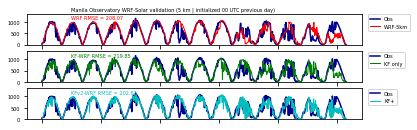

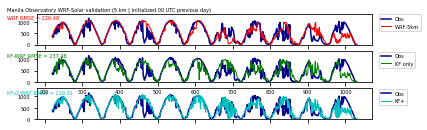

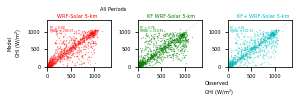

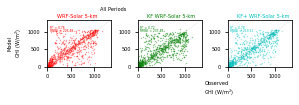

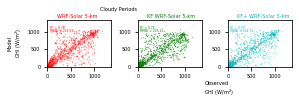

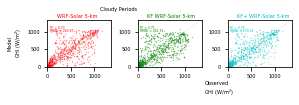

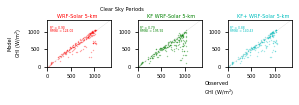

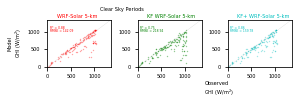

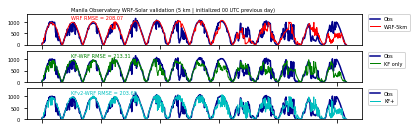

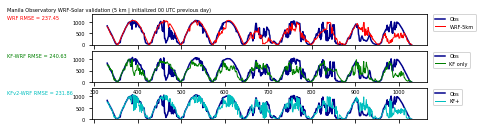

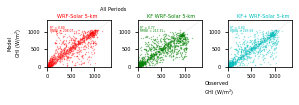

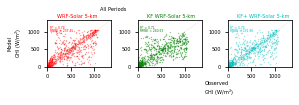

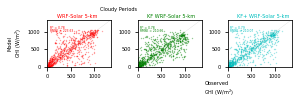

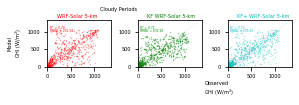

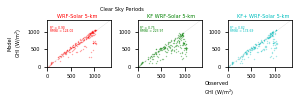

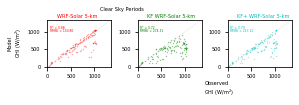

In [35]:
for nb_historical_days in [4,6]:
    #nb_historical_days = 11
    timestep_enough_historical = (nb_historical_days*2)*nb_LTs  
    for t in tqdm(range(len(df_temp))):

        hour = df_temp.loc[t,'Time'].hour
        minutes = df_temp.loc[t,'Time'].minute
        #print(f'Time: {lt_hours}:{lt_minutes:02d} (+{lt})')


        if t >= timestep_enough_historical:
            # slice df
            df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
        else:
            df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
            df_timestep = df_timestep[::-1].reset_index(drop=True)
        df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]

        if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
            df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
            continue

        df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
        df_timestep = df_timestep.reset_index(drop = True)

        # define prediction-bias variance matrix
        W = np.eye(len(predictors_vector))/1000

        # define measurement-bias variance matrix
        V = 0.01

        # define initial error covariance matrix
        Po = np.eye(len(predictors_vector))*5

        # define initial predicted bias
        xo = np.zeros(len(predictors_vector)).reshape(len(predictors_vector),1)

        measurement_GHI = []
        old_predicted_GHI = []
        improved_GHI = []
        ground_truths = []
        predicted_coefs = []

        for idx_i, i in enumerate(df_timestep.index):
            if recursive_calculation_covariance_matrices == True:
                # --------------------------------------------
                #  Calculate matrices of covariance of errors
                # --------------------------------------------
                if idx_i > nb_historical_days:
                    mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                    mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                    # old method
                    W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                    V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))

                    # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                    # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                    # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))

            # ----------------------------
            #           Predict
            # ----------------------------

            if idx_i == 0:
                # predicted mean bias
                x_pred = np.zeros_like(xo)
                if add_noise_in_predictions == True:
                    x_pred = xo + np.random.multivariate_normal(mean=[0.5]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = xo

                # predicted bias covariance matrix
                P = Po + W

            else:
                # predicted mean bias
                if add_noise_in_predictions == True:
                    x_pred = x_pred + np.random.multivariate_normal(mean=[0]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = x_pred
                #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors

                # predicted bias covariance matrix
                P = P + W

            # ----------------------------
            #           Update
            # ----------------------------

            # compute transition matrix based on the current predictors for this timestep
            H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
            H = np.asarray([1] + H).reshape(1, len(predictors_vector))
            if nonlinear_predictions == True:
                H = [predictor**idx_predictor for idx_predictor, predictor in enumerate(H)]

            predicted_coefs.append(x_pred)
            improved_GHI.append(dot(H,x_pred))
            df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]

            # compute residual mean bias and residual bias covariance
            if add_noise_in_predictions == True:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs'] + np.random.normal(loc = 0, scale = V)
            else:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
            residual_mean = new_measurement - dot(H,x_pred)
            residual_covariance = dot(H, P).dot(H.T) + V

            # compute Kalman gain based on the transition matrix and residual covariance
            K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
            K = np.nan_to_num(K, nan = 0)

            # update mean bias after incorporating measurements
            x_pred = x_pred + dot(K,residual_mean)

            # update bias covariance matrix after incorporating measurements
            #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
            P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)

            measurement_GHI.append(new_measurement)
            old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
            ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])

        # assign final prediction
        df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
    # calculate overall error metrics for this group of predictors
    df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

    df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
    df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

    rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
    mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])

    print('\n\n**************************')
    print(f'Predictors: {predictors_vector}')
    print(f'- RMS: {rms}')
    print(f'- MAE: {mae}')
    #print(f'- MSE: {mse}')
    print(f'- MBE: {mbe}')

    # assign post-processed timesteps to original dataframe
    copy = df_temp[['Time','GHI_pred_improved']]


    df_updated = df.merge(copy,how='outer',on="Time")
    df_updated['kf_obs'] = np.abs(df_updated['GHI_pred_improved'] - df_updated['ghi_obs'])
    df_updated['wrf_obs'] = np.abs(df_updated['ghi_mod'] - df_updated['ghi_obs'])
    
    #Kalman Filter Alone
    def kf_only(df):
        if ((df['GHI_pred_improved'] >= 0)):
            kf_only = df['GHI_pred_improved']
        else:
            kf_only = df['ghi_mod']
        return(kf_only)
    
    df_updated["GHI_pred_kf_only"] = df_updated.apply(kf_only, axis=1)
    
    #recording HITs and MISS for each LT or time of the day (Contingency Table)
    def lim(df):
        if ((df['GHI_pred_improved'] >= 0) & (df['kf_obs'] <= df['wrf_obs'])):
            lim = 'HIT' #by KF
        else:
            lim = 'MISS'
        return(lim)

    df_updated["flag_hit"] = df_updated.apply(lim, axis=1)

    table = df_updated.groupby(['LT','flag_hit']).agg({'flag_hit': ['count']}).droplevel(axis=1, level=0).reset_index()#.to_csv('summary.csv')
    table = pd.pivot_table(table, values='count', index=['LT'],columns=['flag_hit']).reset_index()#.to_csv('summary.csv')

    #this will be used to know whether the WRF or KF output is better for each LT or time of the day
    def hit(t):
        if ((t['HIT'] >= 0) & (t['HIT'] >= t['MISS'])):
            hit = 'KF'
        else:
            hit = 'WRF'
        return(hit)
    table["final"] = table.apply(hit, axis=1)

    df_updated = df_updated.merge(table,how='outer',on="LT")
    #depending on contingency table for each LT or time of the day 
    #use KF or WRF output
    def final_pred(df):
        if ((df['GHI_pred_improved'] >= 0) & (df['final'] == 'KF')):
            lim = df['GHI_pred_improved']
        else:
            lim = df['ghi_mod']
        return(lim)

    df_updated["GHI_pred_improved_fin"] = df_updated.apply(final_pred, axis=1)
    df_updated = df_updated.sort_values(by='Time').reset_index()
    #example for nb_historical_days=4
    #we are only correcting for 29 while 48 points are retained
    df_updated = df_updated[['Time',  'CMP22_Total_Solar', 'SPN1_Total_Solar',
           'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
           'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
           'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
           'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
           'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs',
           'ens', 'domain', 'station_name', 'variable', 'ghi_mod', 'YY',
           'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias', 'LT',
           'GHI_pred_kf_only', 'GHI_pred_improved_fin']]
    # calculate overall error metrics for this group of predictors
    df_updated = df_updated.loc[~np.isnan(df_updated['GHI_pred_improved_fin'])]
    df_updated = df_updated.loc[~np.isnan(df_updated['ghi_obs'])]

    rms = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'], squared=False)
    mae = mean_absolute_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
    mse = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
    mbe = np.mean(df_updated['GHI_pred_improved_fin'] - df_updated['ghi_obs'])

    ts_all(5, df_updated)
    ts_cut(5, df_updated)
    scat_all(5, df_updated)
    scat_cut(5, df_updated)
    scat_cloudy_all(5, df_updated)
    scat_cloudy_cut(5, df_updated)
    scat_clear_all(5, df_updated)
    scat_clear_cut(5, df_updated)

